In [20]:
import numpy as np
import pandas as pd
import time
import random
import matplotlib.pyplot as plt
import math
import copy

In [21]:
df_distancias = pd.read_csv("Caso II - Matriz de Distancias.csv", delimiter= ",", index_col= 0)
dist_matrix = df_distancias.values
ubicacion_clientes = pd.read_csv("Caso II - Ubicacion Clientes.csv", delimiter= ",", index_col= 0)
datos_prueba = pd.read_csv("Caso II - Set de Datos.csv", delimiter= ",", index_col= 0)
test_data = datos_prueba.values

In [22]:
column_mapping = {column_name: int(column_name) for column_name in datos_prueba.columns}

# Reassign columns with new integer names
datos_prueba.rename(columns=column_mapping, inplace=True)

In [23]:
#DEFINO LA MATRIZ LLEGA
def llega(x):
   return True if x <= 2 else False

df_llega = df_distancias.applymap(llega)

In [24]:
#DEFINIMOS CONSTANTES
#PROBLEMA
TARIFA_PROMEDIO = 1200
AHORRO = 0.05
TARIFA_OBJETIVO = TARIFA_PROMEDIO * (1-AHORRO)
CANTIDAD_DE_CLIENTES_POR_CAMION = 3
CANTIDAD_DE_CAMIONES = 6
TONS_MAX_POR_CAMION = 12
#METAHEURISTICA
CANTIDAD_DE_PEDIDOS_CAMBIAR = 3

In [25]:
#FUNCIONES
#generarSolucionInicial
def generarSolucionInicial(pedidos): #PEDIDOS ES UNA PANDAS SERIES CON LOS PEDIDOS
    #-----------------------CAMBIAR DATOS_PRUEBA 2 ----------------------------------------------------------------------
    pedidos = pedidos[pedidos > 0 ].index #Elimina los clientes con 0 toneladas y toma el index(Nombre de los clientes)
    pedidos = pedidos.to_list() #Lo convierte a lista
    pedidos.pop() #Elimino el ultimo (el total)
    pedidos_por_asignar = pedidos #Asigno todos lo pedidos a pedidos por asignar
    clientes_por_camion = [[] for _ in range(CANTIDAD_DE_CAMIONES)] #Armo la lista con los pedidos de los camiones por cliente
    pedidos_no_asignados = [] #Inicializo un lista con pedidos no asignados
    cantidad_clientes = len(pedidos_por_asignar) 
    for i in range(cantidad_clientes): #Recorro toda la lista de clientes para ese dia
        cliente = pedidos_por_asignar.pop() #Elimino el ultimo cliente de la lista de clientes a la vez que le asigno el cliente eliminado a la variable cliente
        rand = random.randint(0, CANTIDAD_DE_CAMIONES-1) #genero un numero aleatorio entero del 0 al 5
        camion_cliente = clientes_por_camion[rand] #Elijo el camion al aleatoriamente
        cantidad_clientes = len(camion_cliente)
        if cantidad_clientes < CANTIDAD_DE_CLIENTES_POR_CAMION: #Verifico que el camion no tenga 3 clientes
            llega_list = []
            for j in range(cantidad_clientes):
                cliente_en_camion = camion_cliente[j]
                llega = df_llega.loc[cliente_en_camion,cliente]
                llega_list.append(llega)
            llega_array = np.array(llega_list)
            llega_todos = np.prod(llega_array) #Si da 0 es decir que hay al menos un false, entonces no llega a todos
            if(llega_todos):
                clientes_por_camion[rand].append(cliente)
            else:
                pedidos_no_asignados.append(cliente)
        else:
            pedidos_no_asignados.append(cliente)
    return clientes_por_camion, pedidos_no_asignados #Devuelve dos listas ej: ([['A', 'B'],['J', 'H','D'] ] ['C','E','F'])

def pedidosPorCamion(clientes_por_camion, pedidos): #RECIBE UNA LISTA Y UN A PANDAS.SERIES DEVUELVE UNA LIST DE SERIES
    pedidos_por_camion = []
    for camion in clientes_por_camion: #Recorro los clientes por camion
            pedido = pedidos[camion] #Selecciono los pedidos de ese cliente(las tons)
            pedidos_por_camion.append(pedido)
    return pedidos_por_camion #Una lista de pandas.Series

#Calcular costo de la solucion
def tonsRepartidasPorCamion(pedidos_por_camion): #RECIBE UNA LIST DE SERIES Y DEVULEVE UNA LISTA DE NUMEROS
    tons = 0
    tons_repartidas_por_camion = []
    toneladas_no_repartidas = 0
    for pedido in pedidos_por_camion:
        tons = pedido.values.sum()
        if(tons <= TONS_MAX_POR_CAMION):
            tons_repartidas_por_camion.append(tons)
        else:
            tons_repartidas_por_camion.append(TONS_MAX_POR_CAMION)
            toneladas_no_repartidas += tons-TONS_MAX_POR_CAMION
    return tons_repartidas_por_camion, toneladas_no_repartidas

#SUPER OK
def costoPorCamion(tons_repartidas_por_camion):
    costo_por_camion = []
    for tons in tons_repartidas_por_camion:
        costo = float(0)
        if (tons == 0):
            costo = 5000
        elif (tons < 4):
            costo = 5600
        elif (tons < 6.5):
            costo = tons * 1400
        elif (tons < 9.5):
            costo = tons * 1200
        else:
            costo = tons * 1000
        costo_por_camion.append(costo)
    return costo_por_camion

def tonsNoAsignadas(pedidos_no_asignados, pedidos):
    return pedidos[pedidos_no_asignados].values.sum();

def costoTotal(costo_por_camion, tons_no_asignadas_o_no_repartidas):
    costo_total = sum(costo_por_camion) + tons_no_asignadas_o_no_repartidas * 3000
    return costo_total

def tonsRepartidas(tons_repartidas_por_camion):
    tons_repartidas = sum(tons_repartidas_por_camion)
    return tons_repartidas


In [121]:
def generarVecino1(clientes_por_camion, pedidos_por_asignar): #Recibe una list de lists y una list
    pedidos_no_asignados = []
    #---------SACA UN PEDIDO POR CAMION----------
    for i in range(CANTIDAD_DE_CAMIONES):
        clientes_por_camion_i = clientes_por_camion[i]#Seleccionamos los pedidos del camion i
        len_i = len(clientes_por_camion_i) #Veo cuantos pedidos tiene el camion
        if(len_i > 0):
            rand = random.randint(0, len_i-1) #Selecciono el pedido a cambiar
            cliente_eliminado = clientes_por_camion_i.pop(rand)
            #print("Cliente eliminado: ", cliente_eliminado)
            pedidos_por_asignar.append(cliente_eliminado)
 
    #------AGREGA LOS PEDIDOS ALEATORIAMENTE A LOS CAMIONES------
    cantidad_pedidos_por_asignar = len(pedidos_por_asignar)
    for i in range(cantidad_pedidos_por_asignar):
        cliente_a_asignar = pedidos_por_asignar.pop()
        rand = random.randint(0, CANTIDAD_DE_CAMIONES-1)
        camion = clientes_por_camion[rand]
        cantidad_clientes = len(camion)
        if  cantidad_clientes < CANTIDAD_DE_CLIENTES_POR_CAMION:
            llega_list = []
            for j in range(cantidad_clientes):
                cliente_en_camion = camion[j]
                llega = df_llega.loc[cliente_en_camion,cliente_a_asignar]
                llega_list.append(llega)
            llega_array = np.array(llega_list)
            prod = np.prod(llega_array)
            if(prod):
                clientes_por_camion[rand].append(cliente_a_asignar)
            else:
                pedidos_no_asignados.append(cliente_a_asignar)
        else:
            pedidos_no_asignados.append(cliente_a_asignar)
    return  clientes_por_camion, pedidos_no_asignados #Devuelve una list de lists y una list

In [27]:
T_INICIAL = 1000
T_FINAL = 10
PASO = -10
ITERACIONES_POR_TEMPERATURA = 5


In [122]:

import copy
#HIPERPARÁMETROS DE RECOCIDO SIMULADO
T_INICIAL = 2000
T_FINAL = 10
PASO = -1
ITERACIONES_POR_TEMPERATURA = 10
# clientes_camion,pedidos_no_asignados = generarSolucionInicial(1)
# print(pedidos_no_asignados)
# print(clientes_camion)
pedidos = datos_prueba[5]

def recocidoSimulado(pedidos):
    #INICIALIZACION DE VARIABLES
    clientes_por_camion_min = []
    pedidos_no_asignados_min = []
    costo_por_ton_repartida_min = float('inf')
    pedidos_no_asignados = None
    #pedidos = datos_prueba[1]

    #GENERO LAS SOLUCION INICIAL
    clientes_por_camion, pedidos_no_asignados = generarSolucionInicial(pedidos)
    pedidos_por_camion = pedidosPorCamion(clientes_por_camion, pedidos)
    tons_repartidas_por_camion, tons_no_repartidas = tonsRepartidasPorCamion(pedidos_por_camion = pedidos_por_camion)
    tons_no_asignadas = tonsNoAsignadas(pedidos_no_asignados, pedidos)
    costo_por_camion = costoPorCamion(tons_repartidas_por_camion)
    tons_no_asignadas_o_no_repartidas = tons_no_repartidas + tons_no_asignadas
    #costo_por_camion = costoPorCamion(tons_repartidas_por_camion)
    costo_total = costoTotal(costo_por_camion, tons_no_asignadas_o_no_repartidas)
    tons_repartidas = tonsRepartidas(tons_repartidas_por_camion)
    #CALCULO EL COSTO POR TON REPARTIDA
    costo_por_ton_repartida_1 = costo_total/tons_repartidas
    #print('clientes_por_camion:', clientes_por_camion)
    #print('pedidos_no_asignados:', pedidos_no_asignados)
    clientes_por_camion_1 = clientes_por_camion
    pedidos_no_asignados_1 = pedidos_no_asignados
    clientes_por_camion_min = clientes_por_camion
    pedidos_no_asignados_min = pedidos_no_asignados
    costo_por_ton_repartida_min = costo_por_ton_repartida_1
    #print("costo_por_ton_repartida_min:", costo_por_ton_repartida_min)

    for t in range(T_INICIAL, T_FINAL, PASO):
        #print("-----------------Temperatura:", t,"----------------")
        #print("costo_por_ton_repartida_min", costo_por_ton_repartida_min)
        #print("clientes_por_camion_min:", clientes_por_camion_min)
        #print("pedidos_no_asignados_min:", pedidos_no_asignados_min)
        for n in range(ITERACIONES_POR_TEMPERATURA):
            clientes_por_camion, pedidos_no_asignados = generarVecino1(copy.deepcopy(clientes_por_camion_1), copy.deepcopy(pedidos_no_asignados_1))
            #print("clientes_por_camion:", clientes_por_camion)
            #print("pedidos_no_asignados:", pedidos_no_asignados)
            pedidos_por_camion = pedidosPorCamion(clientes_por_camion, pedidos)
            tons_repartidas_por_camion, tons_no_repartidas = tonsRepartidasPorCamion(pedidos_por_camion = pedidos_por_camion)
            tons_no_asignadas = tonsNoAsignadas(pedidos_no_asignados, pedidos)
            costo_por_camion = costoPorCamion(tons_repartidas_por_camion)
            tons_no_asignadas_o_no_repartidas = tons_no_repartidas + tons_no_asignadas
            #costo_por_camion = costoPorCamion(tons_repartidas_por_camion)
            costo_total = costoTotal(costo_por_camion, tons_no_asignadas_o_no_repartidas)
            tons_repartidas = tonsRepartidas(tons_repartidas_por_camion)
            #CALCULO EL COSTO POR TON REPARTIDA
            costo_por_ton_repartida = costo_total/tons_repartidas
            delta = costo_por_ton_repartida_1 - costo_por_ton_repartida #Calculo delta como Sa - Sb
            if delta < 0 : #Si la solucion nueva es peor que la anterio delta < 0
                p = math.e**(delta/t)
                rand_0_1 = random.random()
                #print("p:",  f"{p:.2f}") 
                #print("rand:", f"{rand_0_1:.2f}")
                if p > rand_0_1 :
                    #ACEPTO UNA PEOR SOLUCION
                    ##print("----Tomo solucion peor---")
                    costo_por_ton_repartida_1 = costo_por_ton_repartida
                    pedidos_no_asignados_1 = pedidos_no_asignados
                    clientes_por_camion_1 = clientes_por_camion
                #else:
                    #SE QUEDA CON LA SOLUCION ANTERIOR
                    # costo_por_ton_repartida_1 = copy.copy(costo_por_ton_repartida_1)
                    # pedidos_no_asignados_1 = pedidos_no_asignados_1[:]
                    # clientes_por_camion_1 = clientes_por_camion_1[:]
            else:
                #ACEPTA LA SOLUCION MEJOR
                #ACA ESTA EL PROBLEMA
                costo_por_ton_repartida_1 = costo_por_ton_repartida
                pedidos_no_asignados_1 = pedidos_no_asignados
                clientes_por_camion_1 = clientes_por_camion

            if costo_por_ton_repartida_min > costo_por_ton_repartida:
                #ACTUALIZA A LA MEJOR SOLUCION HASTA AHORA
                costo_por_ton_repartida_min = costo_por_ton_repartida
                clientes_por_camion_min = clientes_por_camion
                pedidos_no_asignados_min = pedidos_no_asignados
            # #print("costo_por_ton_repartida:",costo_por_ton_repartida)
            # print("costo_por_ton_repartida_1:", costo_por_ton_repartida_1)
            # print("clientes_por_camion:", clientes_por_camion)
            # print("Pedidos_no_asignados:", pedidos_no_asignados)
            # print("clientes_por_camion_1:", clientes_por_camion_1)
            # print("pedidos_no_asignados_1:", pedidos_no_asignados_1)


    return costo_por_ton_repartida_min, clientes_por_camion_min, pedidos_no_asignados_min

In [104]:
T_INICIAL = 1000
T_FINAL = 100
PASO = -10
ITERACIONES_POR_TEMPERATURA = 50

pedidos = datos_prueba[8]
costo_por_ton_repartida_min, clientes_por_camion_min, pedidos_no_asignados_min = recocidoSimulado(pedidos)
print(costo_por_ton_repartida_min)
print(clientes_por_camion_min)
print(pedidos_no_asignados_min)

costo_por_ton_repartida_min: 3348.8372093023254
1247.0588235294117
[['A', 'O'], ['G', 'K'], ['M', 'D'], ['I', 'C', 'E'], ['H', 'F', 'L'], ['B', 'J', 'N']]
[]


In [105]:
resultados = []
for i in range(1,10):
    pedidos = datos_prueba[i]
    costo_por_ton_repartida_min, clientes_por_camion_min, pedidos_no_asignados_min = recocidoSimulado(pedidos)
    resultados.append(costo_por_ton_repartida_min)
print(resultados)


costo_por_ton_repartida_min: 1687.8048780487804
costo_por_ton_repartida_min: 2568.4210526315787
costo_por_ton_repartida_min: 1641.6666666666667
costo_por_ton_repartida_min: 2018.1818181818182
costo_por_ton_repartida_min: 2709.090909090909
costo_por_ton_repartida_min: 1729.4117647058824
costo_por_ton_repartida_min: 2463.4146341463415
costo_por_ton_repartida_min: 2256.603773584906
costo_por_ton_repartida_min: 1810.909090909091
[1102.127659574468, 1077.7777777777778, 1072.7272727272727, 1078.5714285714287, 1143.75, 1093.3333333333333, 1098.2456140350878, 1292.5373134328358, 1120.0]


In [85]:
import statistics
statistics.mean(resultados)

1101.6163126103831

In [113]:
resultadosCalibracion = []
PASO = -10
ITERACIONES_POR_TEMPERATURA = 10

for T_INICIAL in range(2000, 1000, -100): #TEMPERATURA INICIAL 10
    res_T_Final = []
    for T_FINAL in range(210, 10, -25): #TEMPERATURA FINAL 8
                corrida = []
                for i in range(10):
                    costo_por_ton_repartida_min, clientes_por_camion_min, pedidos_no_asignados_min = recocidoSimulado(pedidos)
                    corrida.append(costo_por_ton_repartida_min)
                res_T_Final.append(corrida)
    resultadosCalibracion.append(res_T_Final)

In [118]:
resultadosCalibracion
promedio_calibracion = []
for  i in range(0,10):
    list_i = []
    for j in range(0,8):
        list_i.append(statistics.mean(resultadosCalibracion[i][j]))
    promedio_calibracion.append(list_i)

promedio_calibracion



[[1209.777349684806,
  1201.895069481168,
  1172.3647888849503,
  1159.5957475305704,
  1187.0390104966718,
  1195.4339280790894,
  1166.1127112135177,
  1180.9542574361124],
 [1170.040086257828,
  1156.6946610736934,
  1154.7959844814684,
  1175.150156071527,
  1205.7490367908135,
  1173.077695154308,
  1166.979240517547,
  1159.5509275670565],
 [1203.826469156321,
  1179.6273263027297,
  1176.1802937206164,
  1143.3034400635206,
  1186.2730316278703,
  1159.1579325692228,
  1181.0822174586388,
  1172.6436793493244],
 [1163.5160797433075,
  1244.1446114846433,
  1205.449801902076,
  1236.0590841748299,
  1171.3822167975393,
  1218.467715704297,
  1167.1544460812706,
  1180.6691234392847],
 [1185.7585620208572,
  1203.156522017409,
  1210.419831277777,
  1190.151466743052,
  1230.8409587393921,
  1200.5479883350388,
  1193.6486027413448,
  1200.1865771868415],
 [1196.017093290692,
  1212.1266207535048,
  1208.6819963631174,
  1199.0152718777786,
  1180.3842427733557,
  1180.48232921963

In [119]:
df_result_calibracion = pd.DataFrame(promedio_calibracion)
df_result_calibracion = df_result_calibracion.astype(int)
df_result_calibracion



,0,1,2,3,4,5,6,7
0,1209,1201,1172,1159,1187,1195,1166,1180
1,1170,1156,1154,1175,1205,1173,1166,1159
2,1203,1179,1176,1143,1186,1159,1181,1172
3,1163,1244,1205,1236,1171,1218,1167,1180
4,1185,1203,1210,1190,1230,1200,1193,1200
5,1196,1212,1208,1199,1180,1180,1182,1178
6,1195,1211,1196,1202,1197,1208,1195,1186
7,1209,1208,1214,1223,1189,1208,1193,1166
8,1272,1239,1200,1190,1201,1236,1215,1197
9,1236,1226,1193,1195,1208,1191,1201,1213


<AxesSubplot:>

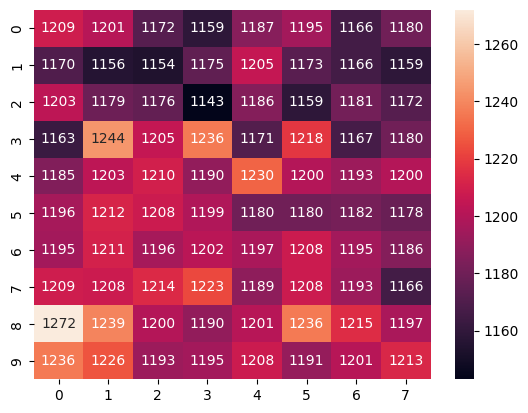

In [125]:
import seaborn as sns
sns.heatmap(df_result_calibracion, annot = True, fmt= 'd')

In [88]:
resultadosCalibracion

[]

In [39]:
datos_prueba

,1,2,3,4,5,6,7,8,9,10
Cliente,,,,,,,,,,
A,4,3,5,2,6,6,6,5,5,1
B,6,6,5,4,1,3,7,6,4,7
C,1,6,6,2,6,7,5,1,4,5
D,8,6,5,2,8,2,2,2,5,7
E,4,1,2,4,2,3,2,6,3,6
F,3,1,6,8,6,5,5,3,5,8
G,3,2,3,7,4,3,3,8,4,4
H,5,8,5,2,4,8,4,2,7,1
I,5,2,3,4,2,6,1,4,5,7


In [66]:
ton_prom = []

for i in range(1000):
    clientes_por_camion_min = []
    pedidos_no_asignados_min = []
    costo_por_ton_repartida_min = float('inf')
    pedidos_no_asignados = None
    #pedidos = datos_prueba[1]

    #GENERO LAS SOLUCION INICIAL
    clientes_por_camion, pedidos_no_asignados = generarSolucionInicial(pedidos)
    pedidos_por_camion = pedidosPorCamion(clientes_por_camion, pedidos)
    tons_repartidas_por_camion, tons_no_repartidas = tonsRepartidasPorCamion(pedidos_por_camion = pedidos_por_camion)
    tons_no_asignadas = tonsNoAsignadas(pedidos_no_asignados, pedidos)
    costo_por_camion = costoPorCamion(tons_repartidas_por_camion)
    tons_no_asignadas_o_no_repartidas = tons_no_repartidas + tons_no_asignadas
    #costo_por_camion = costoPorCamion(tons_repartidas_por_camion)
    costo_total = costoTotal(costo_por_camion, tons_no_asignadas_o_no_repartidas)
    tons_repartidas = tonsRepartidas(tons_repartidas_por_camion)
    #CALCULO EL COSTO POR TON REPARTIDA
    costo_por_ton_repartida_1 = costo_total/tons_repartidas
    #print('clientes_por_camion:', clientes_por_camion)
    #print('pedidos_no_asignados:', pedidos_no_asignados)
    clientes_por_camion_1 = clientes_por_camion
    pedidos_no_asignados_1 = pedidos_no_asignados
    clientes_por_camion_min = clientes_por_camion
    pedidos_no_asignados_min = pedidos_no_asignados
    costo_por_ton_repartida_min = costo_por_ton_repartida_1
    #print("costo_por_ton_repartida_min:", costo_por_ton_repartida_min)
    ton_prom.append(costo_por_ton_repartida_min)


In [73]:
ton_prom_1 = ton_prom[1:]
ton_prom_2 = ton_prom[:999]
ton_prom = np.array(ton_prom)
ton_prom_1 = np.array(ton_prom_1)
ton_prom_2 = np.array(ton_prom_2)
ton_dif = ton_prom_2 - ton_prom_1

print(np.abs(ton_dif).mean())
ton_prom.std()

748.6945877424845


712.299210996236

In [78]:
datos_prueba

,1,2,3,4,5,6,7,8,9,10
Cliente,,,,,,,,,,
A,4,3,5,2,6,6,6,5,5,1
B,6,6,5,4,1,3,7,6,4,7
C,1,6,6,2,6,7,5,1,4,5
D,8,6,5,2,8,2,2,2,5,7
E,4,1,2,4,2,3,2,6,3,6
F,3,1,6,8,6,5,5,3,5,8
G,3,2,3,7,4,3,3,8,4,4
H,5,8,5,2,4,8,4,2,7,1
I,5,2,3,4,2,6,1,4,5,7


In [146]:
def opt_2(cpc):
    #ELIJO 2 CAMIONES DIFERENTES AL AZAR
    #genero 2 numeros al azar diferentes
    rand1 = random.randint(0, CANTIDAD_DE_CAMIONES-1)
    while True:
        rand2 = random.randint(0, CANTIDAD_DE_CAMIONES-1)
        if rand1 != rand2:
            break
    #genero los 2 camiones
    camion_1 = cpc[rand1]
    camion_2 = cpc[rand2]

    #SELECCIONO UN CLIENTE AL AZAR DE CADA CAMION
    rand_cliente_1 = random.randint(0, len(camion_1) - 1 )
    rand_cliente_2 = random.randint(0, len(camion_2) - 1 )

    #Elimino el cliente del camion    
    cliente_2 = camion_1.pop(rand_cliente_1)
    cliente_1 = camion_2.pop(rand_cliente_2)

    #Verifico que se puedan poner uno en cada lugar]
    #Pruebo si puedo meter al cliente_1 en el camion_2
    llega_list_1 = []
    for cliente in camion_2:
        llega_1 = df_llega.loc[cliente,cliente_2]
        llega_list_1.append(llega_1)
        llega_todos_1 = all(llega_list_1)
    llega_list_2 = []
    for cliente in camion_1:
        llega_2 = df_llega.loc[cliente,cliente_1]
        llega_list_2.append(llega_2)
        llega_todos_2 = all(llega_list_2)

    #Si tanto el cliente_1 y el cliente_2 estan a menos de 2km de los otros clientes del camion los asigno cruzo y si no los dejo como estaban
    if(llega_todos_1 and llega_todos_2):
        #Los asigno cruzados
        camion_1.append(cliente_1)
        camion_2.append(cliente_2)
    else:
        #Los dejo como estaban
        camion_1.append(cliente_2)
        camion_2.append(cliente_1)


    #Retorno los clientes por camion
    return cpc

In [169]:
clientes_por_camion = [['O', 'J'],['M', 'K', 'I'], ['F', 'H', 'B'], ['N', 'G', 'E'], ['L', 'A'], ['C', 'D']]
print(opt_2(clientes_por_camion))

[['O', 'J'], ['M', 'K', 'I'], ['F', 'H', 'B'], ['N', 'G', 'E'], ['L', 'A'], ['C', 'D']]


In [145]:
print(clientes_por_camion)
#ELIJO 2 CAMIONES DIFERENTES AL AZAR
#genero 2 numeros al azar diferentes
rand1 = random.randint(0, CANTIDAD_DE_CAMIONES-1)
while True:
    rand2 = random.randint(0, CANTIDAD_DE_CAMIONES-1)
    if rand1 != rand2:
        break
#genero los 2 camiones
camion_1 = clientes_por_camion[rand1]
camion_2 = clientes_por_camion[rand2]

#SELECCIONO UN CLIENTE AL AZAR DE CADA CAMION
rand_cliente_1 = random.randint(0, len(camion_1) - 1 )
rand_cliente_2 = random.randint(0, len(camion_2) - 1 )

#Elimino el cliente del camion    
cliente_2 = camion_1.pop(rand_cliente_1)
cliente_1 = camion_2.pop(rand_cliente_2)

#Verifico que se puedan poner uno en cada lugar]
#Pruebo si puedo meter al cliente_1 en el camion_2
llega_list_1 = []
for cliente in camion_2:
    llega_1 = df_llega.loc[cliente,cliente_2]
    llega_list_1.append(llega_1)
    llega_todos_1 = all(llega_list_1)
llega_list_2 = []
for cliente in camion_1:
    llega_2 = df_llega.loc[cliente,cliente_1]
    llega_list_2.append(llega_2)
    llega_todos_2 = all(llega_list_2)

#Si tanto el cliente_1 y el cliente_2 estan a menos de 2km de los otros clientes del camion los asigno cruzo y si no los dejo como estaban
if(llega_todos_1 and llega_todos_2):
    #Los asigno cruzados
    camion_1.append(cliente_1)
    camion_2.append(cliente_2)
else:
    #Los dejo como estaban
    camion_1.append(cliente_2)
    camion_2.append(cliente_1)
print(clientes_por_camion)

[['H', 'G'], ['I', 'M', 'K'], ['J', 'B', 'F'], ['N', 'O', 'E'], ['D', 'L'], ['C', 'A']]
[['H', 'G'], ['M', 'K', 'I'], ['J', 'F', 'B'], ['N', 'O', 'E'], ['D', 'L'], ['C', 'A']]
